In [25]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np

from torchvision.models import resnet50, resnet18
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, default_collate
from tqdm import trange
from matplotlib import pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_cifar = CIFAR10(
    root='data/',
    download=True,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Resize([224, 224])
    ])
)

train_cifar, val_cifar = random_split(train_cifar, lengths=[0.8, 0.2])

test_cifar = CIFAR10(
    root='data/',
    download=True,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Resize([224, 224])
    ])
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [4]:
BATCH_SIZE=100

trainloader = DataLoader(
    train_cifar, 
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    # collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
)

valloader = DataLoader(
    val_cifar,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    # collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
)

testloader = DataLoader(
    test_cifar, 
    batch_size=BATCH_SIZE, 
    num_workers=0,
    shuffle=True,
    # collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
)

In [5]:
def test_model(model, loss_fn, testloader): 
    
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    loss = 0
    
    with torch.no_grad():
        
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
    
            test_pred = model(images)
        
            loss += loss_fn(test_pred, labels)

            _, cat = torch.max(test_pred, 1)
            
            correct += torch.sum(cat == labels.data)
            total += labels.size(0)

    return loss, correct / total 

def train_model(model, dataloaders, loss_fn, optimizer, epochs): 
    model.to(device)
    
    starting_time = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    val_acc_hist = []
    
    for i in (t := trange(epochs)): 
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for images, labels in dataloaders[phase]: 
                images = images.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): 
                    outs = model(images)
                    loss = loss_fn(outs, labels)
                
                _, preds = torch.max(outs, 1)
                
                if phase == 'train': 

                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc 
                best_model = copy.deepcopy(model.state_dict())
                
            if phase == 'val': 
                val_acc_hist.append(epoch_acc)
                t.set_description("loss %.2f accuracy %.2f" % (epoch_loss, epoch_acc))



    model.load_state_dict(best_model)
     
    time_elapsed = time.time() - starting_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
        
    plt.plot([x for x in range(epochs)], [x.cpu() for x in val_acc_hist])
    
    return model



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

loss 1.74 accuracy 0.46: 100%|██████████| 10/10 [02:46<00:00, 16.65s/it]

Training complete in 2m 47s
Best val Acc: 0.457400


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

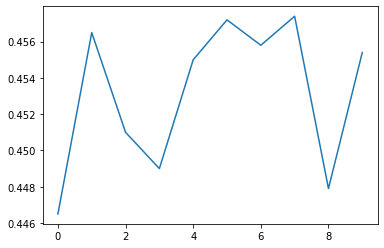

In [6]:
res50 = resnet50(weights="IMAGENET1K_V2")
for param in res50.parameters():
    param.requires_grad = False


res50.fc = nn.Linear(2048, 10)
should_train_params = []
for param in res50.parameters(): 
  if param.requires_grad: 
    should_train_params.append(param)
sgd = optim.SGD(should_train_params, lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train_model(
    res50, 
    {'train': trainloader, 'val': valloader},
    loss_fn, 
    sgd,
    10
)



In [7]:
test_model(res50, loss_fn, testloader)

(tensor(170.1001, device='cuda:0'), tensor(0.4662, device='cuda:0'))

In [8]:
res50.eval()
teacher = res50

In [20]:
def teach(teacher, dataloader, loss_fn, epochs, teach=True):
  T = 10
  alpha = 0.8 if teach else 1
  student = resnet18(pretrained=False)
  student.fc = nn.Linear(512, 10)

  student.to(device)

  optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)


  for i in (t := trange(epochs)): 
    running_loss = 0.0
    running_corrects = 0.0
    total = 0
            
    for images, labels in dataloader: 
      images = images.to(device)
      labels = labels.to(device)
                
      optimizer.zero_grad()

      student_outs = student(images)

      teacher_outs = teacher(images)

      softmax = nn.Softmax(dim=1)

      student_soft = softmax(student_outs)
      student_hard = softmax(student_outs/T)

      teacher_hard = softmax(teacher_outs/T)

      soft_loss = loss_fn(student_soft, labels)
      hard_loss = loss_fn(student_hard, teacher_hard)

      loss = (1 - alpha) * soft_loss + (alpha * (T**2)) * hard_loss 

      loss.backward()
      optimizer.step()

      _, preds = torch.max(student_outs, 1)

      running_loss += loss.data * images.size(0)
      running_corrects += torch.sum(preds == labels.data)
    

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
      
    t.set_description("loss %.2f accuracy %.2f" % (epoch_loss, epoch_acc))


  return student


In [17]:
loss_fn = nn.CrossEntropyLoss()
student = teach(teacher, trainloader, loss_fn, 5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
loss 183.69 accuracy 0.62: 100%|██████████| 5/5 [01:23<00:00, 16.60s/it]


In [19]:
test_model(student, loss_fn, testloader)

(tensor(307.0378, device='cuda:0'), tensor(0.5865, device='cuda:0'))

In [26]:
res_model = teach(teacher, trainloader, loss_fn, 5, False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
loss 229.18 accuracy 0.56: 100%|██████████| 5/5 [01:22<00:00, 16.48s/it]


In [27]:
test_model(res_model, loss_fn, testloader)

(tensor(343.3620, device='cuda:0'), tensor(0.5426, device='cuda:0'))

When we train a smaller model using a teacher, our model will learn some features that are more complicated from the teacher model. For instance, let us consider that we have 3 classes, dogs, cats and cars. When we use a highly temprature for our softmax, we expect the teacher model to have a high probability for dogs and cats for a cat picture and a very low probability for car class, because cats and dogs are very alike. Teacher model tries to learn this similarity to student model very fast. 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

loss 0.66 accuracy 0.84: 100%|██████████| 10/10 [03:56<00:00, 23.65s/it]

Training complete in 3m 57s
Best val Acc: 0.838800


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

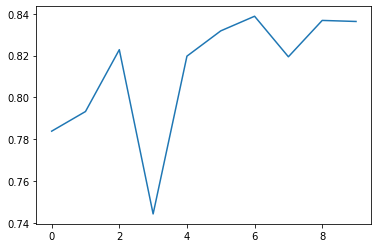

In [34]:
res50_full = resnet50(pretrained=True)
res50_full.fc = nn.Linear(2048, 10)

sgd = optim.SGD(res50_full.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train_model(
    res50_full, 
    {'train': trainloader, 'val': valloader},
    loss_fn, 
    sgd,
    10
)


In [35]:
test_model(res50_full, loss_fn, trainloader)

(tensor(17.8695, device='cuda:0'), tensor(0.9859, device='cuda:0'))

Fine tuning the whole model is very slow but it improve the accuracy. There are some reasons for this matter. The resnet model is not trained for cifar-10 dataset and therefore we can say that the model is not familiar with the features in this dataset and fine tuning the whole model is helping to recognize such that features additionaly to the old ones that model has been trained for. 